Import Libraries

In [13]:
import pandas as pd
import numpy as np
import datetime
import math
import joblib

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, confusion_matrix, roc_curve,
                             mean_squared_error, mean_absolute_error, r2_score)

import matplotlib.pyplot as plt


Load data & quick EDA

In [14]:
df = pd.read_csv("data/india_housing_prices.csv")
print("Rows, Columns:", df.shape)
display(df.head())


Rows, Columns: (250000, 23)


,ID,State,City,Locality,Property_Type,BHK,Size_in_SqFt,Price_in_Lakhs,Price_per_SqFt,Year_Built,...,Age_of_Property,Nearby_Schools,Nearby_Hospitals,Public_Transport_Accessibility,Parking_Space,Security,Amenities,Facing,Owner_Type,Availability_Status
0,1,Tamil Nadu,Chennai,Locality_84,Apartment,1,4740,489.76,0.10,1990,...,35,10,3,High,No,No,"Playground, Gym, Garden, Pool, Clubhouse",West,Owner,Ready_to_Move
1,2,Maharashtra,Pune,Locality_490,Independent House,3,2364,195.52,0.08,2008,...,17,8,1,Low,No,Yes,"Playground, Clubhouse, Pool, Gym, Garden",North,Builder,Under_Construction
2,3,Punjab,Ludhiana,Locality_167,Apartment,2,3642,183.79,0.05,1997,...,28,9,8,Low,Yes,No,"Clubhouse, Pool, Playground, Gym",South,Broker,Ready_to_Move
3,4,Rajasthan,Jodhpur,Locality_393,Independent House,2,2741,300.29,0.11,1991,...,34,5,7,High,Yes,Yes,"Playground, Clubhouse, Gym, Pool, Garden",North,Builder,Ready_to_Move
4,5,Rajasthan,Jaipur,Locality_466,Villa,4,4823,182.90,0.04,2002,...,23,4,9,Low,No,Yes,"Playground, Garden, Gym, Pool, Clubhouse",East,Builder,Ready_to_Move


Plot price distribution and missing values count.

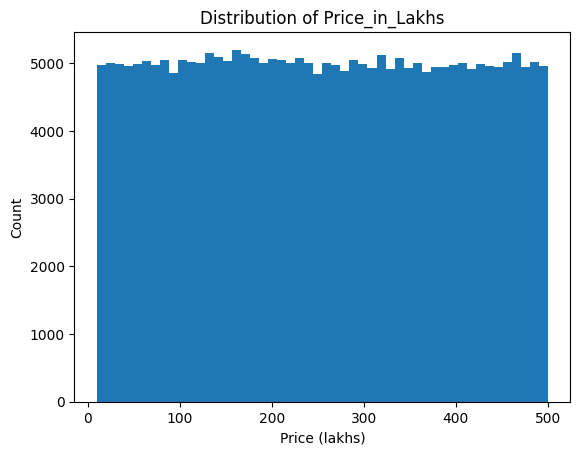

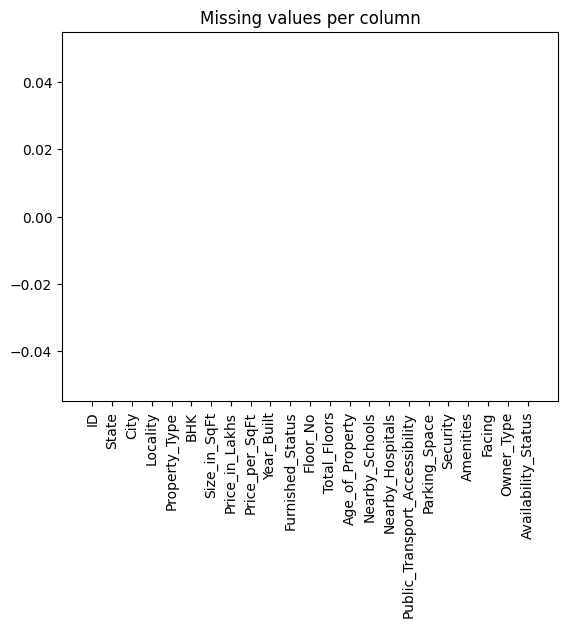

In [15]:
# Price distribution
plt.figure()
plt.hist(df['Price_in_Lakhs'].dropna(), bins=50)
plt.title("Distribution of Price_in_Lakhs")
plt.xlabel("Price (lakhs)")
plt.ylabel("Count")
plt.show()

# Missing values bar
plt.figure()
missing = df.isnull().sum().sort_values(ascending=False)
plt.bar(range(len(missing)), missing.values)
plt.xticks(range(len(missing)), missing.index, rotation=90)
plt.title("Missing values per column")
plt.show()


Clean & feature-engineer

In [16]:
# Basic cleaning + type conversion
df = df.drop_duplicates().copy()
df['Price_in_Lakhs'] = pd.to_numeric(df['Price_in_Lakhs'], errors='coerce')
df['Size_in_SqFt'] = pd.to_numeric(df['Size_in_SqFt'], errors='coerce')
df['BHK'] = pd.to_numeric(df['BHK'], errors='coerce')
df['Year_Built'] = pd.to_numeric(df.get('Year_Built'), errors='coerce')

# Fill medians for numeric basics
for c in ['Price_in_Lakhs','Size_in_SqFt','BHK','Year_Built']:
    df[c] = df[c].fillna(df[c].median())

# Features
CURRENT_YEAR = datetime.datetime.now().year
df['Price_per_SqFt'] = df['Price_in_Lakhs'] / df['Size_in_SqFt']
df['Age_of_Property'] = (CURRENT_YEAR - df['Year_Built']).fillna(0)

def count_amen(x):
    if pd.isna(x): return 0
    return len([a for a in str(x).split(',') if a.strip()!=''])
df['Amenities_Count'] = df.get('Amenities', '').apply(count_amen)

# Locality median price per sqft (useful relative feature)
local_med = df.groupby('Locality')['Price_per_SqFt'].median().rename('locality_median_ppsqft')
df = df.merge(local_med, on='Locality', how='left')
df['Price_vs_Median_locality'] = (df['Price_per_SqFt'] - df['locality_median_ppsqft']).fillna(0)


Expected 5-year price & Good_Investment

In [17]:
GROWTH = 0.08  # 8% default
df['Expected_Future_Price_5Y'] = df['Price_in_Lakhs'] * ((1+GROWTH)**5)
df['Expected_ROI_pct_5Y'] = (df['Expected_Future_Price_5Y'] - df['Price_in_Lakhs']) / df['Price_in_Lakhs'] * 100

df['Good_Investment'] = (
    (df['Expected_ROI_pct_5Y'] >= 20) &
    (df['Price_per_SqFt'] <= df['locality_median_ppsqft'] * 1.1) &
    (df['Amenities_Count'] >= 1)
).astype(int)

print("Good investment distribution:\n", df['Good_Investment'].value_counts())


Good investment distribution:
 Good_Investment
1    138080
0    111920
Name: count, dtype: int64


Train/test split + pipeline prep

In [18]:
features = [
    'Price_in_Lakhs','Size_in_SqFt','Price_per_SqFt','Age_of_Property','BHK',
    'Amenities_Count','Price_vs_Median_locality','Owner_Type','Property_Type',
    'Furnished_Status','Availability_Status','City'
]

X = df[features].copy()
y_clf = df['Good_Investment'].copy()
y_reg = df['Expected_Future_Price_5Y'].copy()

# Simple fill for missing category columns to avoid errors
for c in ['Owner_Type','Property_Type','Furnished_Status','Availability_Status','City']:
    if c not in X.columns:
        X[c] = 'Unknown'
    X[c] = X[c].fillna('Unknown')

X_train, X_test, y_clf_train, y_clf_test, y_reg_train, y_reg_test = train_test_split(
    X, y_clf, y_reg, test_size=0.2, random_state=42
)

num_cols = ['Price_in_Lakhs','Size_in_SqFt','Price_per_SqFt','Age_of_Property','BHK','Amenities_Count','Price_vs_Median_locality']
cat_cols = ['Owner_Type','Property_Type','Furnished_Status','Availability_Status','City']

num_pipeline = Pipeline([('imputer', SimpleImputer(strategy='median')), ('scaler', StandardScaler())])
cat_pipeline = Pipeline([('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')), ('ohe', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer([('num', num_pipeline, num_cols), ('cat', cat_pipeline, cat_cols)])


Train a fast classifier

In [19]:
clf_pipeline = Pipeline([
    ('pre', preprocessor),
    ('clf', RandomForestClassifier(n_estimators=120, max_depth=12, min_samples_split=4, random_state=42, n_jobs=-1))
])

clf_pipeline.fit(X_train, y_clf_train)
y_pred = clf_pipeline.predict(X_test)

print("Accuracy:", accuracy_score(y_clf_test, y_pred))
print("Precision:", precision_score(y_clf_test, y_pred, zero_division=0))
print("Recall:", recall_score(y_clf_test, y_pred, zero_division=0))
print("F1:", f1_score(y_clf_test, y_pred, zero_division=0))


Accuracy: 0.9987
Precision: 0.9986957939354418
Recall: 0.9989491230613132
F1: 0.9988224424355514


Plot Confusion Matrix & ROC Curve

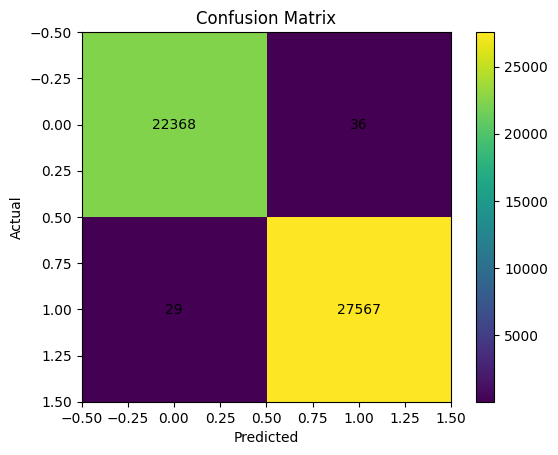

In [20]:
cm = confusion_matrix(y_clf_test, y_pred)
plt.figure()
plt.imshow(cm, interpolation='nearest')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.colorbar()
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, str(cm[i,j]), ha='center', va='center')
plt.show()


ROC curve

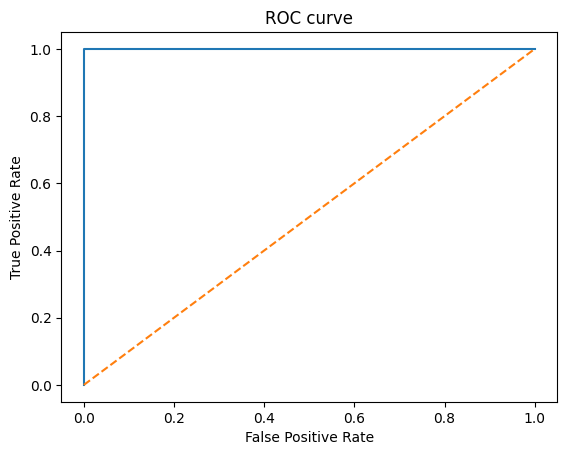

ROC AUC: 0.9999830476066554


In [21]:
# need probabilities
y_proba = clf_pipeline.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(y_clf_test, y_proba)
plt.figure()
plt.plot(fpr, tpr)
plt.plot([0,1],[0,1], linestyle='--')
plt.title("ROC curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()
print("ROC AUC:", roc_auc_score(y_clf_test, y_proba))


Feature importance

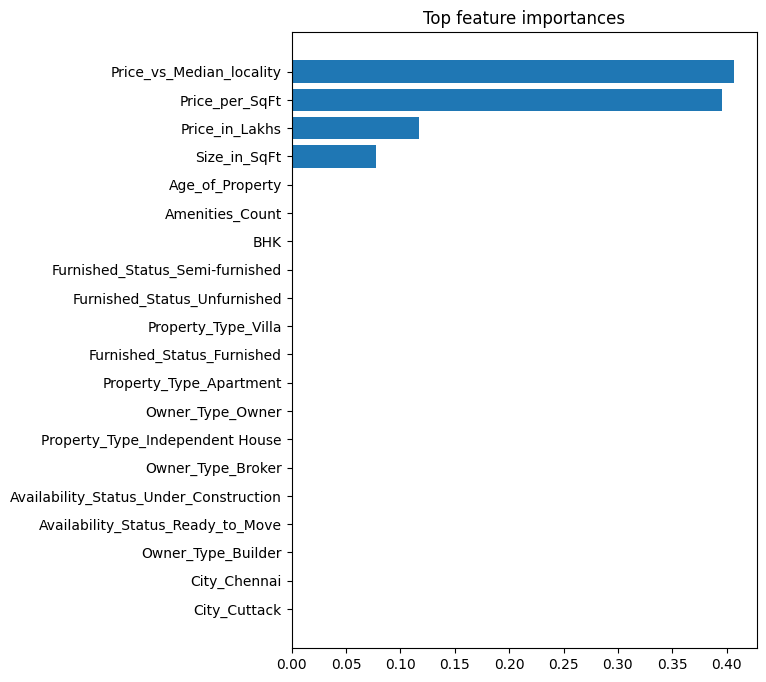

In [22]:
# Get feature names after preprocessing
ohe = clf_pipeline.named_steps['pre'].named_transformers_['cat'].named_steps['ohe']
cat_features_after = list(ohe.get_feature_names_out(cat_cols))
all_features = num_cols + cat_features_after

importances = clf_pipeline.named_steps['clf'].feature_importances_
# select top 20 importances for plot
idx_sorted = np.argsort(importances)[-20:]
plt.figure(figsize=(6,8))
plt.barh(range(len(idx_sorted)), importances[idx_sorted])
plt.yticks(range(len(idx_sorted)), [all_features[i] for i in idx_sorted])
plt.title("Top feature importances")
plt.show()


Train regression model

In [28]:
from sklearn.ensemble import ExtraTreesRegressor

reg_pipeline = Pipeline([
    ('pre', preprocessor),
    ('reg', ExtraTreesRegressor(
        n_estimators=50,
        max_depth=8,
        random_state=42,
        n_jobs=-1
    ))
])

reg_pipeline.fit(X_train, y_reg_train)
y_reg_pred = reg_pipeline.predict(X_test)

print("RMSE:", math.sqrt(mean_squared_error(y_reg_test, y_reg_pred)))
print("MAE:", mean_absolute_error(y_reg_test, y_reg_pred))
print("R2:", r2_score(y_reg_test, y_reg_pred))


RMSE: 1.7816109088905667
MAE: 1.4450423489588278
R2: 0.9999262501878674


Save Models

In [29]:
joblib.dump(clf_pipeline, "models/good_investment_clf.joblib")
joblib.dump(reg_pipeline, "models/future_price_reg.joblib")
joblib.dump(clf_pipeline, "models/good_investment_clf.joblib")
joblib.dump(reg_pipeline, "models/future_price_reg.joblib")


['models/future_price_reg.joblib']

Quick sanity checks & save baseline outputs

In [30]:
# Show shapes and baseline metrics
print("Train shape:", X_train.shape, "Test shape:", X_test.shape)
y_clf_pred = clf_pipeline.predict(X_test)
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_clf_test, y_clf_pred))
cm = confusion_matrix(y_clf_test, y_clf_pred)
import os
os.makedirs("outputs", exist_ok=True)
import numpy as np
np.savetxt("outputs/confusion_matrix.csv", cm, delimiter=",", fmt="%d")


Train shape: (200000, 12) Test shape: (50000, 12)
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     22404
           1       1.00      1.00      1.00     27596

    accuracy                           1.00     50000
   macro avg       1.00      1.00      1.00     50000
weighted avg       1.00      1.00      1.00     50000



EDA deeper

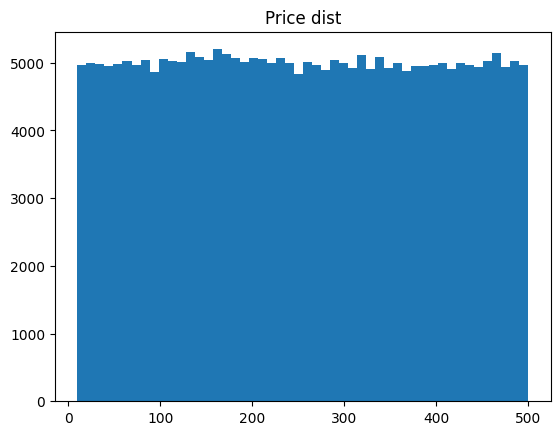

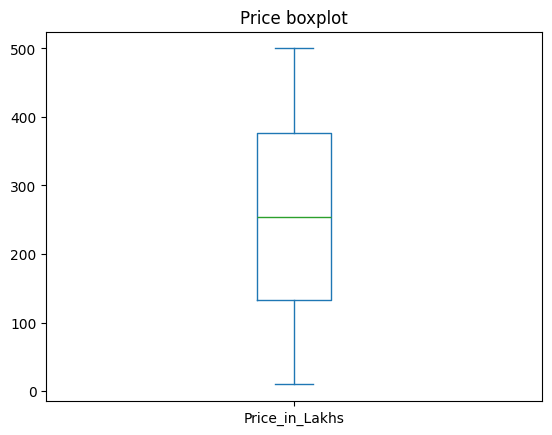

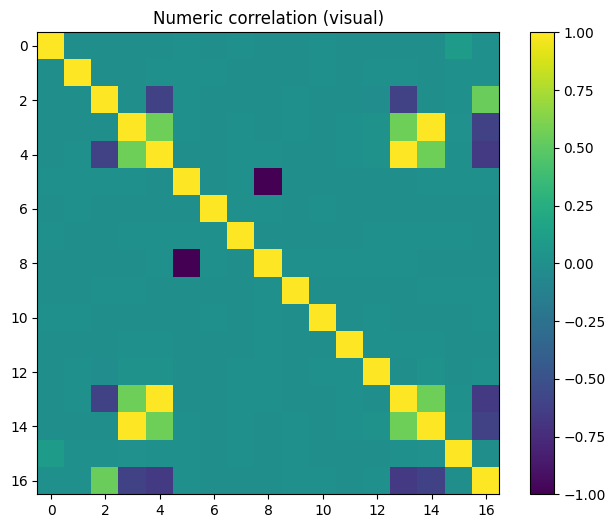

In [31]:
# Price distribution & boxplot
plt.figure(); plt.hist(df['Price_in_Lakhs'].dropna(), bins=50); plt.title("Price dist"); plt.show()
plt.figure(); df['Price_in_Lakhs'].plot.box(); plt.title("Price boxplot"); plt.show()

# Correlation heatmap (numeric)
num = df.select_dtypes(include=[np.number]).corr()
plt.figure(figsize=(8,6)); plt.imshow(num,cmap='viridis'); plt.colorbar(); plt.title("Numeric correlation (visual)"); plt.show()


Improve features

Size_per_BHK

In [32]:
df['Size_per_BHK'] = df['Size_in_SqFt'] / df['BHK']


Age_bucket

In [33]:
df['Age_bucket'] = pd.cut(df['Age_of_Property'], bins=[-1,5,15,30,100], labels=['new','young','mature','old'])


Log_price

In [34]:
df['Log_Price'] = np.log1p(df['Price_in_Lakhs'])


Fast model improvement

In [36]:
import lightgbm as lgb
reg_pipeline = Pipeline([('pre', preprocessor), ('reg', lgb.LGBMRegressor(n_estimators=200, n_jobs=-1))])
reg_pipeline.fit(X_train, y_reg_train)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002716 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1173
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 60
[LightGBM] [Info] Start training from score 374.024685


,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('pre', ...), ('reg', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers contains spar

Quick hyperparameter tuning

In [37]:
from sklearn.model_selection import RandomizedSearchCV
param_dist = {'clf__n_estimators':[80,120,200],'clf__max_depth':[8,12,20,None]}
rs = RandomizedSearchCV(clf_pipeline, param_dist, n_iter=6, cv=3, scoring='f1', n_jobs=-1, random_state=42)
rs.fit(X_train, y_clf_train)
print("Best:", rs.best_params_); best_clf = rs.best_estimator_


Best: {'clf__n_estimators': 80, 'clf__max_depth': None}


feature importance + SHAP

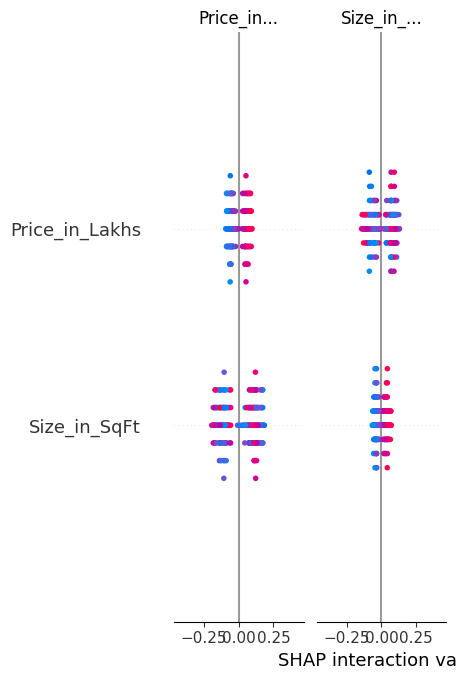

In [39]:
import shap
import numpy as np

# 1) get preprocessor & model from the best pipeline
pre = best_clf.named_steps['pre']         # ColumnTransformer
model = best_clf.named_steps['clf']      # RandomForestClassifier

# 2) transform training data (use a subset to save memory/time)
N = 200   # subset size for SHAP plotting
X_train_sample = X_train.iloc[:N]

Xtr = pre.transform(X_train_sample)

# 3) if it's sparse, convert to dense
try:
    # sparse matrix will have .toarray()
    if hasattr(Xtr, "toarray"):
        Xtr = Xtr.toarray()
except Exception:
    pass

# 4) ensure numeric float dtype
Xtr = Xtr.astype(float)

# 5) build feature names: numeric + one-hot output names
num_cols = ['Price_in_Lakhs','Size_in_SqFt','Price_per_SqFt','Age_of_Property','BHK','Amenities_Count','Price_vs_Median_locality']
cat_cols = ['Owner_Type','Property_Type','Furnished_Status','Availability_Status','City']

# get ohe feature names from the fitted transformer
ohe = pre.named_transformers_['cat'].named_steps['ohe']
cat_feature_names = list(ohe.get_feature_names_out(cat_cols))
feature_names = num_cols + cat_feature_names

# 6) Create TreeExplainer and compute shap values
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(Xtr)   # note: for classifier this may return list

# 7) Select correct shap array for binary classifier
# If shap_values is a list (n_classes), pick the positive class (index 1) for binary
if isinstance(shap_values, list):
    if len(shap_values) == 2:
        shap_vals_to_plot = shap_values[1]
    else:
        # multiclass: you can plot for class 0..k-1; here we pick class 1 if exists
        shap_vals_to_plot = shap_values[1]
else:
    shap_vals_to_plot = shap_values

# 8) Plot summary (feature importance)
shap.summary_plot(shap_vals_to_plot, Xtr, feature_names=feature_names)


Save final artifacts & requirements

In [40]:
import os

os.makedirs("models", exist_ok=True)
os.makedirs("outputs", exist_ok=True)

print("Folders ready!")


Folders ready!


Models ko save karna

In [41]:
import joblib

# Save classifier model
joblib.dump(clf_pipeline, "models/good_investment_clf.joblib")

# Save regressor model
joblib.dump(reg_pipeline, "models/future_price_reg.joblib")

print("Models saved successfully!")


Models saved successfully!


In [42]:
df[['Locality', 'locality_median_ppsqft']].drop_duplicates().to_csv(
    "models/locality_medians.csv", index=False
)

print("Locality median file saved!")


Locality median file saved!


In [43]:
from sklearn.metrics import confusion_matrix
import numpy as np

y_pred = clf_pipeline.predict(X_test)
cm = confusion_matrix(y_clf_test, y_pred)

np.savetxt("outputs/confusion_matrix.csv", cm, delimiter=",", fmt="%d")
print("Confusion matrix saved in outputs folder!")


Confusion matrix saved in outputs folder!


In [44]:
pred_df = pd.DataFrame({
    "Actual": y_reg_test,
    "Predicted": y_reg_pred
})
pred_df.to_csv("outputs/regression_predictions.csv", index=False)

print("Regression predictions saved!")


Regression predictions saved!


In [45]:
clf_loaded = joblib.load("models/good_investment_clf.joblib")
reg_loaded = joblib.load("models/future_price_reg.joblib")

print("Both models loaded successfully!")


Both models loaded successfully!


In [46]:
import os
print("data files:", os.listdir('data'))
print("models:", os.listdir('models'))
print("outputs:", os.listdir('outputs'))


data files: ['india_housing_prices.csv']
models: ['future_price_reg.joblib', 'good_investment_clf.joblib', 'locality_medians.csv']
outputs: ['confusion_matrix.csv', 'regression_predictions.csv']


Test models on a sample input

In [47]:
import pandas as pd
import joblib

# Load models
clf = joblib.load("models/good_investment_clf.joblib")
reg = joblib.load("models/future_price_reg.joblib")

# Example input
sample = pd.DataFrame([{
    'Price_in_Lakhs': 50,
    'Size_in_SqFt': 1000,
    'BHK': 2,
    'Year_Built': 2015,
    'Amenities_Count': 2,
    'Price_per_SqFt': 50/1000,
    'Age_of_Property': 2025-2015,
    'Price_vs_Median_locality': 0,
    'Owner_Type': 'Builder',
    'Property_Type': 'Apartment',
    'Furnished_Status': 'Semi',
    'Availability_Status': 'Available',
    'City': 'Mumbai'
}])

# Predict
is_good = clf.predict(sample)[0]
future_price = reg.predict(sample)[0]

print("Good Investment:", "Yes" if is_good else "No")
print(f"Predicted Price after 5 years: {future_price:.2f} lakhs")


Good Investment: Yes
Predicted Price after 5 years: 73.41 lakhs


c:\Users\verma\OneDrive\Desktop\realestate-advisor\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


Generate evaluation plots

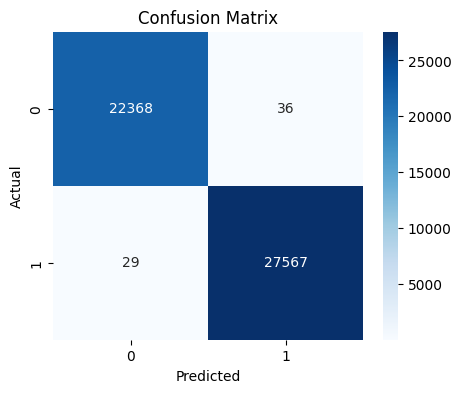

In [48]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

y_pred = clf.predict(X_test)
cm = confusion_matrix(y_clf_test, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


Regression: Predicted vs Actual

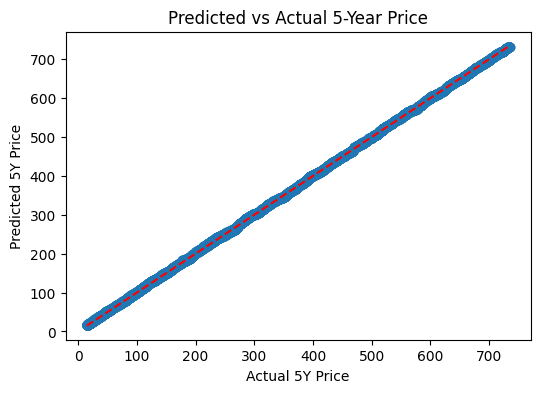

In [49]:
plt.figure(figsize=(6,4))
plt.scatter(y_reg_test, y_reg_pred, alpha=0.6)
plt.plot([y_reg_test.min(), y_reg_test.max()], [y_reg_test.min(), y_reg_test.max()], '--', color='red')
plt.xlabel("Actual 5Y Price")
plt.ylabel("Predicted 5Y Price")
plt.title("Predicted vs Actual 5-Year Price")
plt.show()


MLflow

In [51]:
import mlflow
import mlflow.sklearn

with mlflow.start_run(run_name="RandomForest"):
    clf_pipeline.fit(X_train, y_clf_train)
    f1 = f1_score(y_clf_test, clf_pipeline.predict(X_test))
    mlflow.log_param("n_estimators", 120)
    mlflow.log_metric("f1_score", f1)
    mlflow.sklearn.log_model(clf_pipeline, "good_investment_clf")


2025/12/12 20:18:58 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
